# A smol example of Edge Detection on one of the image slices we have
You need to have the following file:
```./data/train/slice_1_img_168.npy```

In [1]:
#!pip3 install opencv-python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from tqdm import tqdm

# LOADING IMAGES AND JOINTED MASKS

In [131]:
data = pd.read_csv("dataset/train_data.csv")
data.head(2)

,src,slice_num,img_slice,mask_slice,mask_mean_0,mask_mean_1,mask_mean_2,img_mean,lng,lat,np_mask,debris_mean,clean_mean,glacier_perc,label
0,1,150,og_dataset/splits/train/slice_1_img_150.npy,og_dataset/splits/train/slice_1_mask_150.npy,0.185390,0.184795,0.000595,382.686157,445035.967865,4.200787e+06,[[[0 0 1]\n [0 0 1]\n [0 0 1]\n ...\n [0 0...,0.000595,0.184795,0.185390,0
1,1,165,og_dataset/splits/train/slice_1_img_165.npy,og_dataset/splits/train/slice_1_mask_165.npy,0.108147,0.108147,0.000000,370.955048,445035.967865,4.215970e+06,[[[0 0 1]\n [0 0 1]\n [0 0 1]\n ...\n [0 0...,0.000000,0.108147,0.108147,0


In [113]:
def load_arrays(filenames):
    """Function for loading numpy arrays from filenams."""
    return [np.load(filename) for filename in filenames]

def joint_masks(masks):
    return [np.sum(mask[:,:,:2], axis=2) for mask in masks]

In [114]:
filenames = list(data.img_slice)
masknames = list(data.mask_slice)

arrays = load_arrays(filenames)
masks = load_arrays(masknames)
joint_masks = joint_masks(masks)
labels = list(data.label)

In [194]:
print("Training Images:", len(arrays), ", each one with shape:", arrays[0].shape)
print("Masks:", len(masks), ", each one with shape:", masks[0].shape)
print("Joint Masks:", len(joint_masks), ", each one with shape:", joint_masks[0].shape)
print("The", len(labels),"labels are distributed almost equally 0:",len(labels)-sum(labels), "1:",sum(labels))

Training Images: 382 , each one with shape: (512, 512, 15)
Masks: 382 , each one with shape: (512, 512, 3)
Joint Masks: 382 , each one with shape: (512, 512)
The 382 labels are distributed almost equally 0: 190 1: 192


## Finding the global min and max values (not sure if we need this actually)

In [4]:
def get_min_max(arrays, channel):
    """Function for finding the min and max of a specific channel for a list of numpy arrays."""
    mins = np.inf
    maxs = -np.inf
    for array in arrays:
        mins = min(mins, np.min(array[:,:,channel]))
        maxs = max(maxs, np.max(array[:,:,channel]))
        
    return mins, maxs

## Normalising an image [0, 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


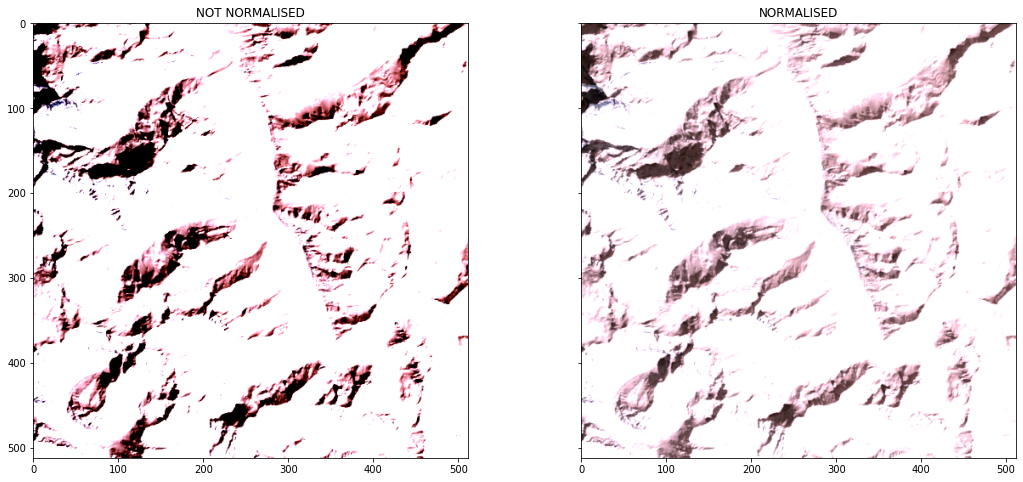

In [142]:
img = np.load("og_dataset/splits/train/slice_2_img_092.npy")
img2 = np.load("og_dataset/splits/train/slice_2_img_092.npy")
for i in range(3):
    #min_, max_ = get_min_max(arrays, i)
    min_ = np.min(img[:,:,i])
    max_ = np.max(img[:,:,i])
    img2[:,:,i] = (img2[:,:,i] - min_) / (max_ - min_)

    
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True,
                         figsize=(18, 8))

axes[0].imshow(img[:,:,:3])
axes[0].set_title('NOT NORMALISED')
axes[1].imshow(img2[:,:,:3])
axes[1].set_title('NORMALISED')
plt.show()

## Creating a grayscale image

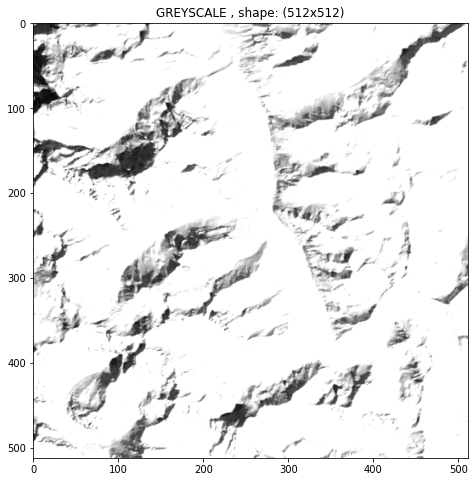

In [143]:
gray = cv2.cvtColor(img[:,:,:3], cv2.COLOR_BGR2GRAY)
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True,figsize=(8, 8))
axes.imshow(gray[:,:], cmap=plt.cm.gray)
axes.set_title("GREYSCALE , shape: (512x512)")
plt.show()

## Edge detection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


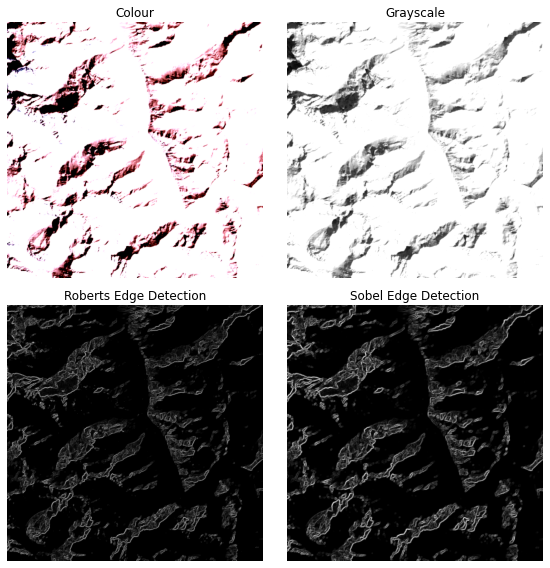

In [149]:
edge_roberts = filters.roberts(gray)
edge_sobel = filters.sobel(gray)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True,
                         figsize=(8, 8))

axes[0][0].imshow(img[:,:,:3])
axes[0][0].set_title('Colour')

axes[0][1].imshow(gray, cmap=plt.cm.gray)
axes[0][1].set_title('Grayscale')

axes[1][0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[1][0].set_title('Roberts Edge Detection')

axes[1][1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1][1].set_title('Sobel Edge Detection')

# turn of the axes so that we just see the images without ticks
for row in axes:
    for col in row:
        col.axis('off')

plt.tight_layout()
plt.show()

# MASK PLOTTING

These are numpy arrays that overlay binary masks from the vector data over the raster images. The three channels correspond to:
1. clean-ice glacier
1. debris-covered glacier
1. whether the pixel belongs to the HKH region (glaciers outside the HKH region, e.g., those in China, were not annotated)



In [15]:
img = np.load("og_dataset/splits/train/slice_2_img_092.npy")
label = np.load("og_dataset/splits/train/slice_2_mask_092.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clean Ice Glacier (Channel 1)')

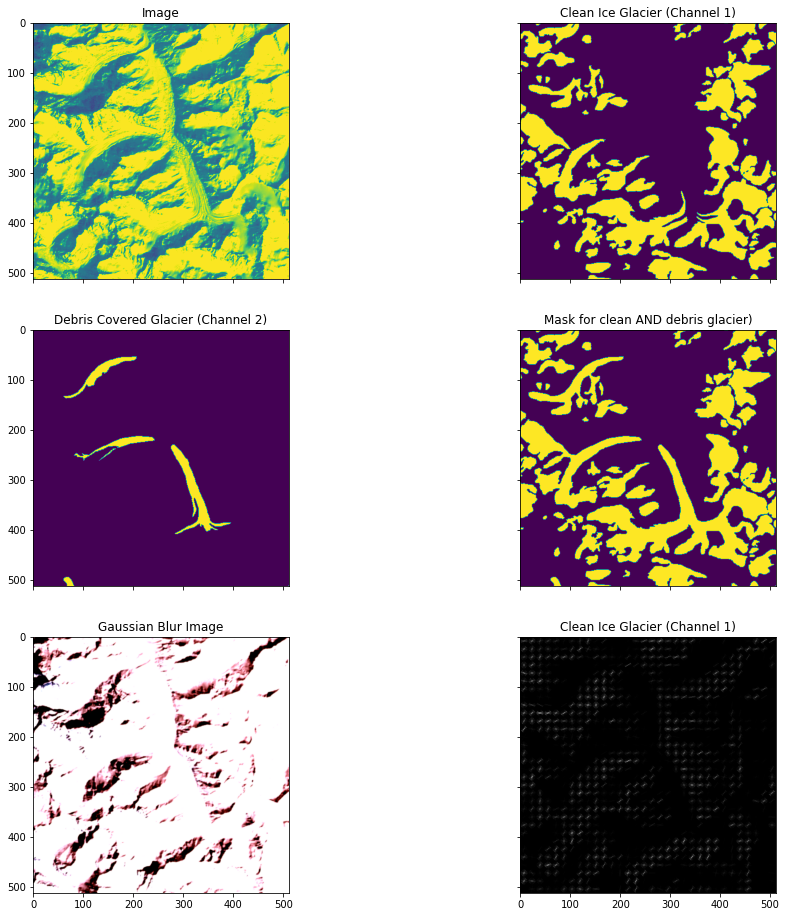

In [150]:
fd, hog_image = hog(img[:,:,10:11], orientations=8, pixels_per_cell=(5, 5),
                    cells_per_block=(1, 1), visualize=True)

gblur = cv2.GaussianBlur(img,(3,3),1)

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True,
                         figsize=(16, 16))

axes[0][0].imshow(img[:,:,10:11])
axes[0][0].set_title('Image')

axes[0][1].imshow(label[:,:,0])
axes[0][1].set_title('Clean Ice Glacier (Channel 1)')

axes[1][0].imshow(label[:,:,1])
axes[1][0].set_title('Debris Covered Glacier (Channel 2)')

axes[1][1].imshow(np.sum(label[:,:,:2], axis=2))
axes[1][1].set_title('Mask for clean AND debris glacier)')

axes[2][0].imshow(gblur[:,:,:3])
axes[2][0].set_title('Gaussian Blur Image')

axes[2][1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
axes[2][1].set_title('Clean Ice Glacier (Channel 1)')

# GAUSSIAN BLUR

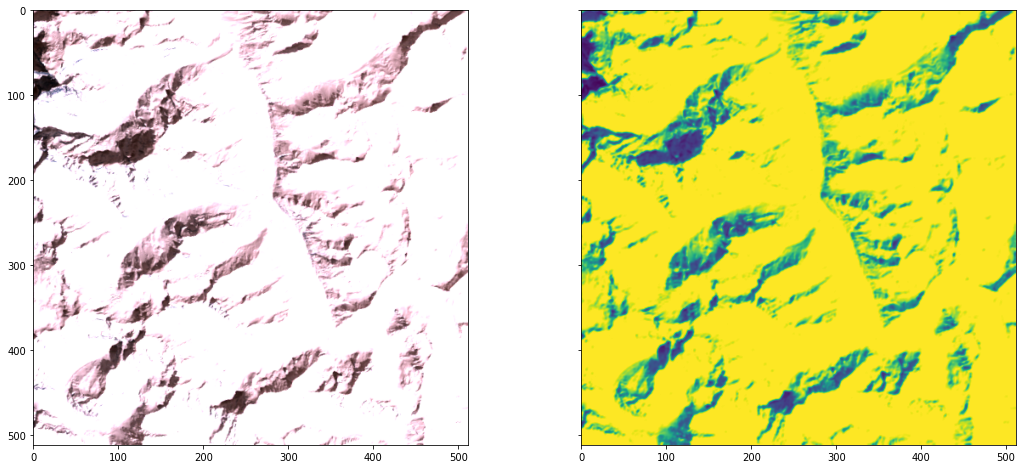

In [101]:
gblur = cv2.GaussianBlur(gray,(3,3),1)
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True,
                         figsize=(18, 8))

axes[0].imshow(img[:,:,:3])
axes[1].imshow(gblur[:,:])

# DOWNSAMPLING

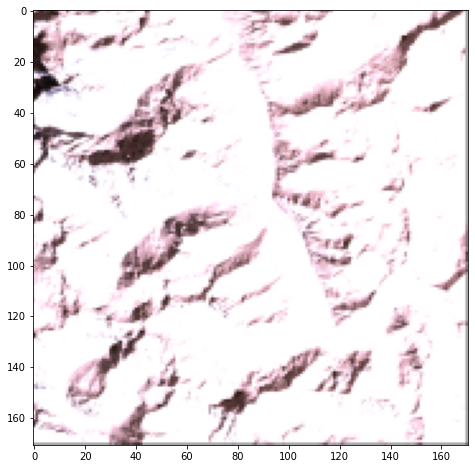

In [87]:
from skimage.measure import block_reduce
down_sample = block_reduce(img, block_size=(3, 3, 1), func=np.mean)
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True,figsize=(18, 8))
axes.imshow(down_sample[:,:,:3])

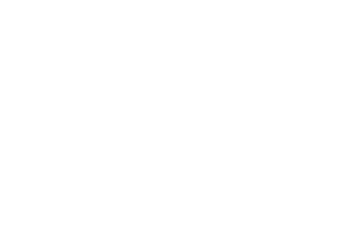

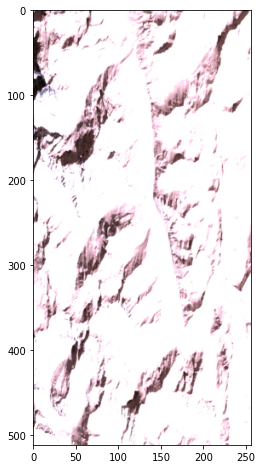

In [91]:
from skimage.transform import resize
resized_img = resize(img, (128*4, 64*4))
plt.axis("off")
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True,figsize=(18, 8))
axes.imshow(resized_img[:,:,:3])

# HISTOGRAM OF ORIENTED GRADIENTS

I just copied the example [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). We might want to reduce the resolution of the image to speed up the process a bit? 

In [168]:
joint_mask = np.sum(label[:,:,:2], axis=2)

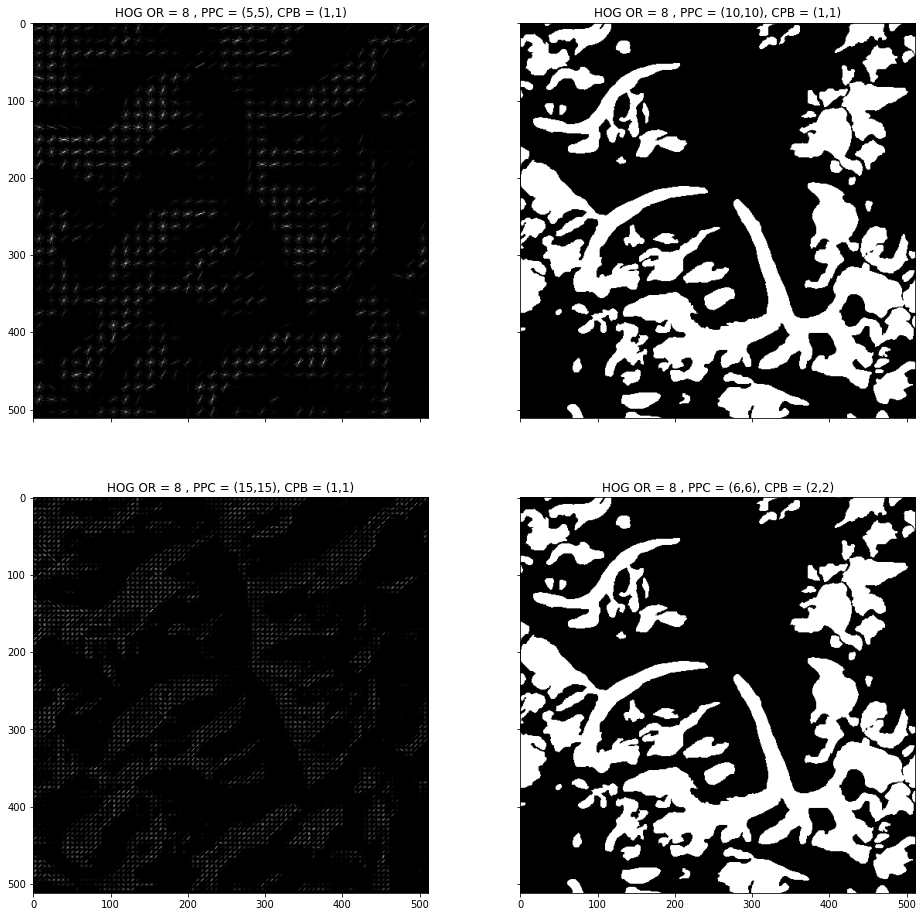

In [170]:
fd, hog_image = hog(img[:,:,:3], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fd2, hog_image2 = hog(img[:,:,:3], orientations=8, pixels_per_cell=(6, 6),
                    cells_per_block=(2, 2), visualize=True)


hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
hog_image_rescaled2 = exposure.rescale_intensity(hog_image2, in_range=(0, 10))

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True,
                         figsize=(16, 16))

axes[0][0].imshow(hog_image_rescaled, cmap=plt.cm.gray)
axes[0][0].set_title('HOG OR = 8 , PPC = (5,5), CPB = (1,1)')

axes[0][1].imshow(np.sum(label[:,:,:2], axis=2), cmap=plt.cm.gray)
axes[0][1].set_title('HOG OR = 8 , PPC = (10,10), CPB = (1,1)')

axes[1][0].imshow(hog_image_rescaled2, cmap=plt.cm.gray)
axes[1][0].set_title('HOG OR = 8 , PPC = (15,15), CPB = (1,1)')

axes[1][1].imshow(np.sum(label[:,:,:2], axis=2), cmap=plt.cm.gray)
axes[1][1].set_title('HOG OR = 8 , PPC = (6,6), CPB = (2,2)')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


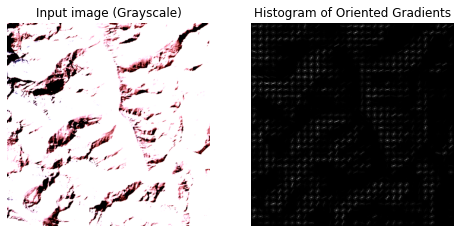

In [145]:
from skimage.feature import hog
from skimage import exposure

fd, hog_image = hog(img[:,:,:3], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img[:,:,:3], cmap=plt.cm.gray)
ax1.set_title('Input image (Grayscale)')

# Rescale histogram for better display


ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [203]:
X_train_sub = arrays[0:100]
y_train_sub = labels[0:100]

In [206]:
X_test = arrays[100:200]
y_test = labels[100:200]

array([[[-1.7699648 , -1.5762353 , -1.6766024 , ..., -1.4910637 ,
         -0.8453466 , -0.23543234],
        [-1.7699648 , -1.5762353 , -1.6766024 , ..., -1.4910637 ,
         -0.8622798 , -0.45101047],
        [-1.7699648 , -1.5762353 , -1.6766024 , ..., -1.4910637 ,
         -0.8622798 , -0.45101047],
        ...,
        [-0.32593802, -0.29675427, -0.20129308, ..., -0.77603096,
         -0.56353056,  0.69041395],
        [-0.31429264, -0.25225058, -0.14455041, ..., -0.82824856,
         -0.507893  ,  0.6280095 ],
        [-0.16290273, -0.14099137, -0.03106508, ..., -0.70840496,
         -0.507893  ,  0.6280095 ]],

       [[-1.7699648 , -1.5762353 , -1.6766024 , ..., -1.4910637 ,
         -0.8453466 , -0.23543234],
        [-1.7699648 , -1.5762353 , -1.6766024 , ..., -1.4910637 ,
         -0.8622798 , -0.45101047],
        [-1.7699648 , -1.5762353 , -1.6766024 , ..., -1.4910637 ,
         -0.8622798 , -0.45101047],
        ...,
        [-0.6403632 , -0.5303986 , -0.42826372, ..., -

- DATA IS LOADED.
- HOGS ARE CREATED
- GRID SEARCH FOR orientations, pixels_per_cell, cells_per_block
- KNN TEST¿?

In [207]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(5, 100, 10)
scores = {}
scores_list = []

for k in tqdm(k_range):
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train_sub,y_train_sub)
    y_predict = knn_model.predict(X_test)
    scores[k]= metrics.accuracy_score(y_test, y_predict)
    scores_list.append(scores[k])
scores

  0%|          | 0/10 [00:19<?, ?it/s]


ValueError: Found array with dim 4. Estimator expected <= 2.